## Post-training Investigation

This notebook uses different methods to assess the quality of generated EEG data. By doing so, we will inform ourselves of possible improvement that can be made to the WGAN's arch to generate more realisitc-looking data.

In [1]:
# imports
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from scipy.signal import sosfiltfilt, butter, sosfilt
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch
from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm
from ot import sliced_wasserstein_distance

import torch
import keras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.EEGModalNet.models.WGAN import WGAN_GP
from src.EEGModalNet.utils import CustomModelCheckpoint, StepLossHistory
from scipy.stats import wasserstein_distance
import mne

# helper functions
def plot_segment(x, x_gen, sub, seg, duration=1024, db=False):
    x1 = x[sub*60:(sub+1)*60].flatten()
    x_gen1 = x_gen[sub*60:(sub+1)*60].flatten()
    plt.figure(figsize=(20, 2))
    segment = x1[seg*duration:(seg+1)*duration]
    segment_gen = x_gen1[seg*duration:(seg+1)*duration]
    plt.plot(segment, label='real')
    plt.plot(segment_gen, label='fake')
    plt.legend()
    plt.xlim(0, duration)
    plt.show()
    f, Pxx = welch(segment, fs=128, nperseg=256)
    f, Pxx_gen = welch(segment_gen, fs=128, nperseg=256)
    if db:
        Pxx = 10*np.log10(Pxx)
        Pxx_gen = 10*np.log10(Pxx_gen)
    plt.figure(figsize=(5, 5))
    plt.plot(f, Pxx, label='real')
    plt.plot(f, Pxx_gen, label='fake')
    plt.legend()
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0, figsize=(10, 5)):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=figsize)
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    if db:
        psd = 10*np.log10(psd)
    plt.plot(freq, psd, label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def plot_2d_components(x, x_gen, ch=0, method='tsne'):
    x, x_gen = x[:, :, [ch]], x_gen[:, :, [ch]]
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=20, method='barnes_hut', n_jobs=-1)
    if method == 'pca':
        tsne = PCA(n_components=2)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

# critic performance
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_D_performance(x, sub, model, pos):
    return sigmoid(model.critic(x.float().to('mps'), sub.to('mps'), pos.to('mps')).mean().item())

def plot_real_fake_hist(x, x_gen, model):
    real_scores = model.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()
    fake_scores = model.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()
    plt.hist(real_scores, bins=20, alpha=0.5, label='real')
    plt.hist(fake_scores, bins=20, alpha=0.5, label='fake')
    # plt.xlim(4, 12)
    plt.legend()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]


def print_act_dist(model, x, sub, pos):
    generator = model.critic.model
    layer_outputs = [layer.output for layer in generator.layers[1:]] 

    activation_model = keras.Model(inputs=generator.layers[0].input, outputs=layer_outputs)

    # Activation_model returning all the intermediate outputs
    # updated_data = model.critic.pos_emb(x[:batch_size].float().to('mps'),
                                        # sub[:batch_size].to('mps'),
                                        # pos[:batch_size].to('mps'))
    activations = activation_model.predict(x)

    # 'activations' is a list of arrays containing the outputs from each layer
    acts = []
    for i, activation in enumerate(activations):
        acts.append(activation.mean())
        print(f"Layer {i}: mean={activation.mean():.3f}, std={activation.std():.3f}")
    
    plt.plot(acts)

def print_act_generator(model):
    generator = model.generator.model
    layer_outputs = [layer.output for layer in generator.layers[1:]] 
    activation_model = keras.Model(inputs=generator.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict((keras.random.normal((100, 128))))

    # 'activations' is a list of arrays containing the outputs from each layer
    acts = []
    for i, activation in enumerate(activations):
        acts.append(activation.mean())
        print(f"Layer {i}: mean={activation.mean():.3f}, std={activation.std():.3f}")
    
    plt.plot(acts)
    

# helper functions
def _smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def plot_loss(path, lw=1, smt=30, i=14, j=14):
    history = pd.read_csv(path)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot generator and discriminator loss
    ax[0].plot(_smooth(history['g_loss'], 7), label='Generator Loss', color='blue', linestyle='-', linewidth=2)
    ax[0].plot(_smooth(history['d_loss'], 7), label='Discriminator Loss', color='red', linestyle='-', linewidth=2)
    ax[0].set_title('Generator and Discriminator Loss', fontsize=14)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].grid(True)
    ax[0].legend()

    # Plot gradient penalty and critic gradient norm
    ax[1].plot(_smooth(history['_gp'], 7), label='Gradient Penalty', color='green', linestyle='-', linewidth=2)
    ax[1].plot(_smooth(history['critic_grad_norm'], 7), label='Critic Gradient Norm', color='purple', linestyle='-', linewidth=2)
    ax[1].set_title('Gradient Penalty and Critic Gradient Norm', fontsize=14)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Value', fontsize=12)
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()



/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [2]:
# Real DATA
filtering = True
time_dim = 1024
n_subject = 202
# exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']  # TODO: inspect other channels' data and update this subjects list
exclude_sub_ids = None
channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

# data
data_path = 'data/LEMON_data/EC_8_channels_processed.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject])
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
    sub_ids = xarray.subject[:n_subject].to_numpy()
x = x.to_numpy()

if filtering:
    sos = butter(4, 0.5, btype='high', fs=128, output='sos')
    x = sosfiltfilt(sos, x, axis=-1)
x = torch.tensor(x.copy()).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = torch.tensor(np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis])

pos = torch.tensor(xarray.ch_positions[None].repeat(x.shape[0], 0))
data = {'x': x, 'sub': sub, 'pos': pos}

## Model and Training

In [6]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 128
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=True, use_channel_merger_g=False, use_channel_merger_c=False, kerner_initializer='random_normal',  # glorot_uniform
                  interpolation='bilinear')

torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()
from keras.optimizers.schedules import ExponentialDecay

lr_schedule_g = ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.96, staircase=True)
lr_schedule_d = ExponentialDecay(0.0001, decay_steps=10000, decay_rate=0.96, staircase=True)

wgan_gp.compile(d_optimizer=keras.optimizers.Adam(lr_schedule_d, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(lr_schedule_g, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=5.0)

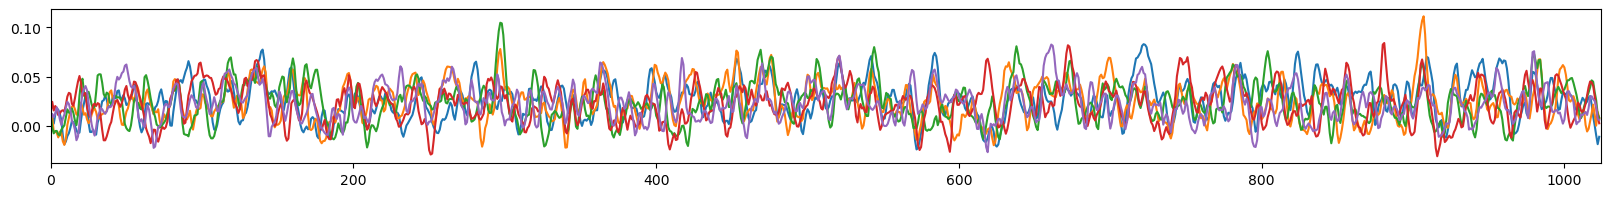

In [8]:
l = 100
x_mean = -4.3159e-06
x_std = 0.4515
x_gen = wgan_gp.generator((keras.random.normal((l, latent_dim), mean=x_mean, stddev=x_std), sub[:l].to('mps'), pos[:l].to('mps'))).cpu().detach().numpy()

plot_overlap(x_gen, n_seg=5, ch=0, time_dim=1024, start_from=10, show=True)

In [ ]:
# Training
batch_size = 64
output_path = 'logs/test_6.1.2025'
# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history,
             CustomModelCheckpoint(output_path, save_freq=10),
             keras.callbacks.CSVLogger(output_path + 'history.csv')]

history = wgan_gp.fit(data, epochs=7, batch_size=batch_size, callbacks=callbacks, shuffle=True)

## Notch Filter

In [ ]:
# notch filter
from scipy.signal import iirnotch, tf2sos, sosfiltfilt

def plot_psd(x, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, c, :].flatten(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=0)
    if db:
        psd = 10*np.log10(psd)
    plt.plot(freq, psd, label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

fs = 128
f0 = 50
Q = 30
w0 = f0 / (fs / 2)  # Normalized Frequency
b, a = iirnotch(w0, Q)

sos = tf2sos(b, a)
x1 = sosfiltfilt(sos, x, axis=-1)

# highpass filter
sos = butter(4, 1, btype='high', fs=128, output='sos')
x2 = sosfiltfilt(sos, x, axis=-1)

plot_psd(x1, fmax=60, label='notch', show=False)
plot_psd(x2, fmax=60, label='highpass', show=False)

plt.legend()
plt.show()

## Feature Extraction
### One channel

Quantifying the similarity between X and X_gen

In [12]:
## feature extraction
# time domain features
def time_domain_features(x, axis=1):
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)  # equivalent to ((x - mean)**3).mean() / std**3 
    kurtosis_ = kurtosis(x, axis=axis)  # equivalent to ((x - mean)**4).mean() / std**4 when fisher=False
    rms = np.sqrt(np.mean(signal**2, axis=1))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=1)

# hjorth parameters
def hjorth_parameters(signal, axis=1):
    # Activity
    activity = np.var(signal, axis=axis)

    # Mobility
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)

    # Complexity
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility

    return np.stack([activity, mobility, complexity], axis=1)

# Spectral features
def spectral_features(signal):
    f, Pxx = welch(signal, fs=128, nperseg=512)
    total_power = np.sum(Pxx, axis=1)
    delta = np.sum(Pxx[:, (f >= 0.25) & (f < 4)], axis=1) / total_power
    theta = np.sum(Pxx[:, (f >= 4) & (f < 8)], axis=1) / total_power
    alpha = np.sum(Pxx[:, (f >= 8) & (f < 13)], axis=1) / total_power
    beta = np.sum(Pxx[:, (f >= 13) & (f <= 30)], axis=1) / total_power
    gamma = np.sum(Pxx[:, (f > 30) & (f <= 50)], axis=1) / total_power
    pxx_entropy = entropy(Pxx, axis=1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=1)

# create a feature matrix
def creat_feature_matrix(signal):
    time_features = time_domain_features(signal)
    hjorth = hjorth_parameters(signal)
    spectral = spectral_features(signal)
    return np.concatenate([time_features, hjorth, spectral], axis=1)

# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

In [ ]:
# compute FID
real_f = hjorth_parameters(signal)
gen_f = hjorth_parameters(signal_gen)
fid = compute_fid(real_f, gen_f)
distance = sliced_wasserstein_distance(real_f, gen_f)

print(f'FID on hjorth parameters: {fid:.5f}',
      f'Wasserstein distance on hjorth parameters: {distance:.5f}')

In [ ]:
# Wasserstein Distance
wdr = wasserstein_distance(signal_gen.flatten(), signal.flatten())
# visualize amplitude histograms
plt.hist(x_gen.flatten(), bins=100, alpha=0.5, label='generated')
plt.hist(x.flatten(), bins=100, alpha=0.5, label='real')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()

### Multi-channel

In [20]:
def time_domain_features_multi_channel(x, axis=-1):  # x: (n_samples, n_channels, n_timepoints)
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)
    kurtosis_ = kurtosis(x, axis=axis)
    rms = np.sqrt(np.mean(x**2, axis=axis))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=-1)  # (n_samples, n_channels, n_features)

def hjorth_parameters_multi_channel(signal, axis=-1): 
    activity = np.var(signal, axis=axis)
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility
    return np.stack([activity, mobility, complexity], axis=-1)

def spectral_features_multi_channel(signal, fs=128, nperseg=512):
    f, Pxx = welch(signal, fs=fs, nperseg=nperseg, axis=-1)
    total_power = np.sum(Pxx, axis=-1)
    delta = np.sum(Pxx[:, :, (f >= 0.25) & (f < 4)], axis=-1) / total_power
    theta = np.sum(Pxx[:, :, (f >= 4) & (f < 8)], axis=-1) / total_power
    alpha = np.sum(Pxx[:, :, (f >= 8) & (f < 13)], axis=-1) / total_power
    beta = np.sum(Pxx[:, :, (f >= 13) & (f <= 30)], axis=-1) / total_power
    gamma = np.sum(Pxx[:, :, (f > 30) & (f <= 50)], axis=-1) / total_power
    pxx_entropy = entropy(Pxx, axis=-1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=-1)


def aggregate_features(real_signal, gen_signal):
    # Extract features
    real_time_features = time_domain_features_multi_channel(real_signal)
    real_hjorth_features = hjorth_parameters_multi_channel(real_signal)
    real_spectral_features = spectral_features_multi_channel(real_signal)
    
    gen_time_features = time_domain_features_multi_channel(gen_signal)
    gen_hjorth_features = hjorth_parameters_multi_channel(gen_signal)
    gen_spectral_features = spectral_features_multi_channel(gen_signal)
    
    # Concatenate features
    real_features = np.concatenate([real_time_features, real_hjorth_features, real_spectral_features], axis=-1)
    gen_features = np.concatenate([gen_time_features, gen_hjorth_features, gen_spectral_features], axis=-1)
    
    # Reshape to 2D for FID
    real_features = real_features.reshape(real_features.shape[0], -1)  # Flatten across channels
    gen_features = gen_features.reshape(gen_features.shape[0], -1)
    
    return real_features, gen_features

# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# real_features, gen_features = aggregate_features(x, x_gen)

# # Normalize features
# real_features = scaler.fit_transform(real_features)
# gen_features = scaler.transform(gen_features)

# fid = compute_fid(real_features, gen_features)
# print("FID Score:", fid)

## Model comparison

In [ ]:
ls = range(20, 1300, 20)
fids = np.zeros([len(ls), 3])

for i in ls:
    model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
    print(f'Epoch {i}')
    wgan_gp.load_weights(model_path)

    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                                pos).cpu().detach()

    signal_gen = x_gen.squeeze().numpy()

    # compute FID on different features
    for j, func in enumerate([hjorth_parameters, spectral_features, time_domain_features]):
        real_f = func(signal)
        gen_f = func(signal_gen)
        fid = compute_fid(real_f, gen_f)
        fids[i//20-1, j] = fid

In [ ]:
plt.plot(ls[7:], fids[7:, 0], label='Hjorth')
plt.plot(ls[7:], fids[7:, 1], label='Spectral')
plt.plot(ls[7:], fids[7:, 2], label='Time')
plt.legend()

## Using best model for downstream task

In [151]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Gender labels
y = xarray.gender[~xarray.subject.isin(exclude_sub_ids)]
y -= 1
y = y.reshape(-1, 1).repeat(x.shape[0]//n_subject, 1).flatten()

In [152]:
# Model
# # intermediate feature extraction using the best model ls[np.argmin(fids.sum(axis=1))]  # 160
# i = 1260
# model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_best_gloss.model.keras'
# wgan_gp.load_weights(model_path)

# X features
f_extractor = keras.Model(wgan_gp.critic.model.layers[0].input, wgan_gp.critic.model.layers[10].output)  # intermediate layer
features = f_extractor(x.float()).cpu().detach().numpy()

In [ ]:
# Classifier
cv_g = GroupShuffleSplit(n_splits=10, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, y, cv=cv_g, groups=sub, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

## Visualize intermediate neurons activations

In [4]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()
i = 1260

In [ ]:
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

generator = wgan_gp.generator
latent_dim=64
features = keras.Model(generator.model.layers[0].input, generator.model.layers[5].output)(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
print(features.shape)
plot_neurons_act(features, across_batch=True, from_to=(1000, 1004), xlim=features.shape[1])

## Critics performance

In [ ]:
critic_performances_real = {}
critic_performances_gen = {}

for i in range(20, 1840, 20):
    dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()
    print(f'>>>>>> {dir.stem.split(".")[2][5:]}')
    critic_performances_real[dir.stem.split(".")[2][5:]] = print_D_performance(x, sub, wgan_gp)
    critic_performances_gen[dir.stem.split(".")[2][5:]] = print_D_performance(x_gen, sub, wgan_gp)

In [ ]:
# concatenate critic performances
critic_performances = pd.concat([pd.Series(critic_performances_real), pd.Series(critic_performances_gen)], axis=1)

# difference in critic performances
critic_performances['diff'] = critic_performances.iloc[:, 1] - critic_performances.iloc[:, 0]
# plot critic performances
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(list(critic_performances_real.values()), label='real')
axes[0].plot(list(critic_performances_gen.values()), label='gen')
axes[1].plot(critic_performances['diff'].values, label='diff')
axes[0].legend()
plt.show()

In [ ]:
## histogram of the critic outputs
i = 140
dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
wgan_gp.load_weights(dir)
x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()

plot_real_fake_hist(x, x_gen, wgan_gp)

## Visual Inspection of X_gen vs. X

In [ ]:
sub = 2
d = 2*1024
s = 10

plot_segment(x_gen, sub, s, db=True)
plot_segment(x, sub, s, d, db=True)

## Evaluate Model Performance
### Setup

In [12]:
def plot_psd_multi_channel(x, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd, label=label)
        ax.set_title(f'Channel {channels[c]}')
    else:
        plt.plot(freq, psd, label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

### Loss

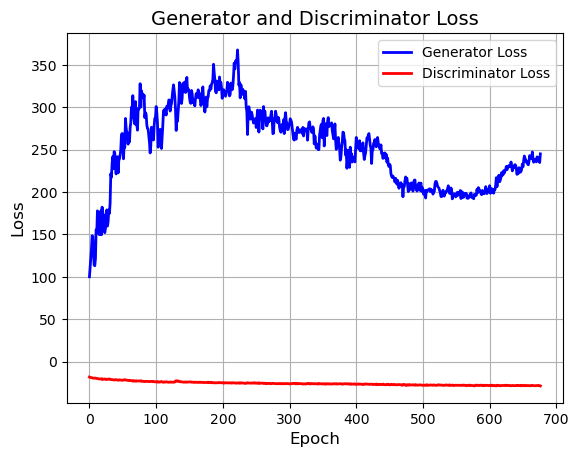

In [6]:
# plot_loss('logs/with_posEmbed_13.01.2025.csv', lw=1, smt=30, i=14, j=14)
stats = pd.read_csv('logs/round2_22.01.2025.csv', index_col=0)
# plt.figure(figsize=(20, 2))
plt.plot(stats['g_loss'], label='Generator Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(stats['d_loss'], label='Discriminator Loss', color='red', linestyle='-', linewidth=2)
plt.title('Generator and Discriminator Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

(0.0, 660.0)

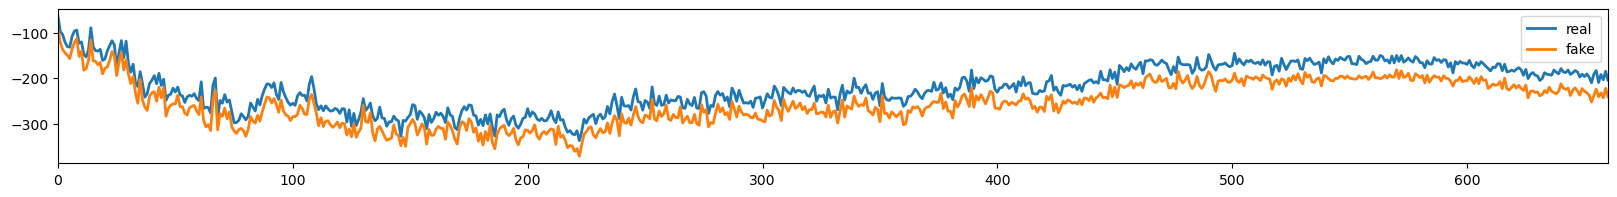

In [7]:
plt.figure(figsize=(20, 2))
plt.plot(stats['_real_pred'], label='real', linewidth=2)
plt.plot(stats['_fake_pred'], label='fake', linewidth=2)
# plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.xlim(0, 660)

In [8]:
from src.EEGModalNet.models.WGAN import WGAN_GP
latent_dim = 128
model = WGAN_GP(time_dim=1024, feature_dim=len(channels),
                latent_dim=latent_dim, n_subjects=202,
                use_sublayer_generator=True,
                use_sublayer_critic=False,
                use_channel_merger_g=False,
                use_channel_merger_c=False,
                kerner_initializer='random_normal',
                interpolation='bilinear')

# load model and history
chkpoint_dir = 'logs/round2_22.01.2025_epoch_660.model.keras'
model.load_weights(chkpoint_dir)

### Generator

In [ ]:
print_act_generator(model)

Channel O1


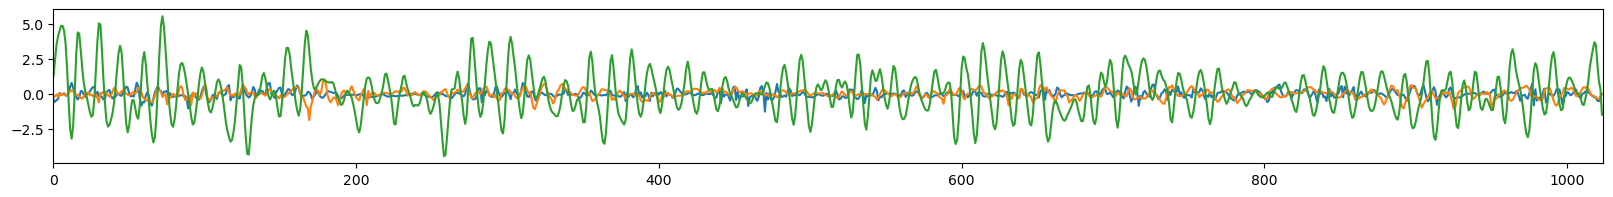

Channel O2


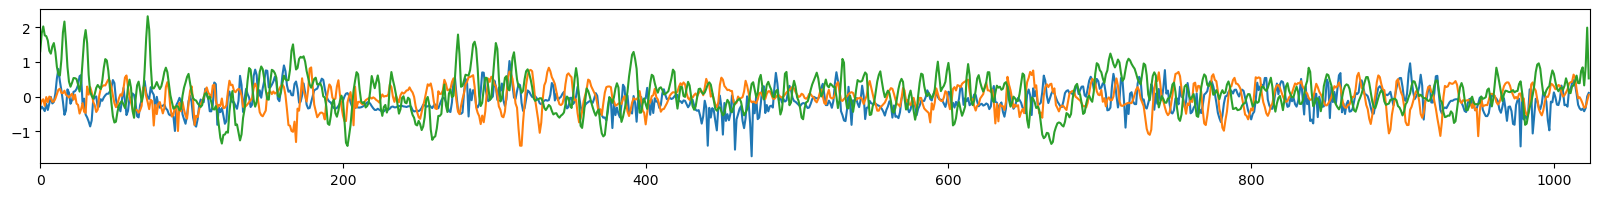

Channel F1


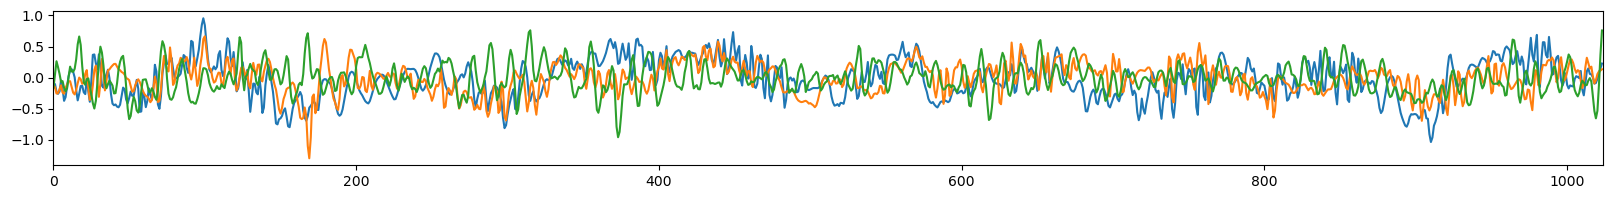

Channel F2


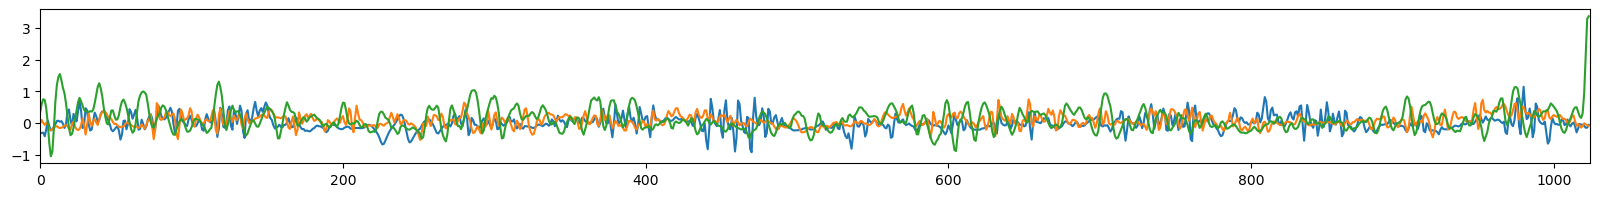

Channel C1


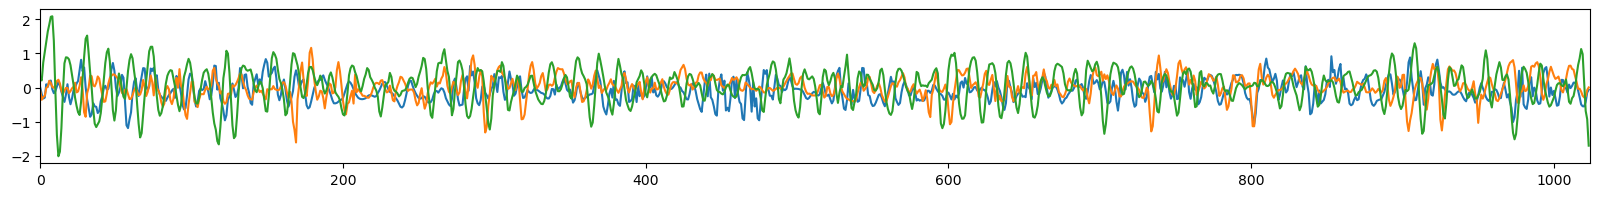

Channel C2


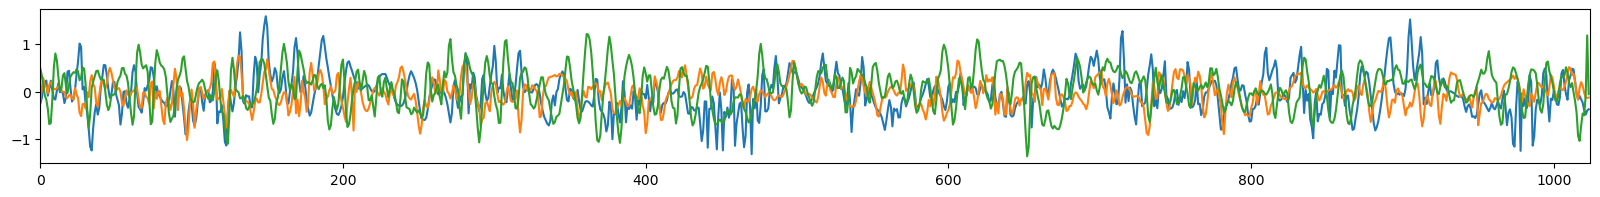

Channel P1


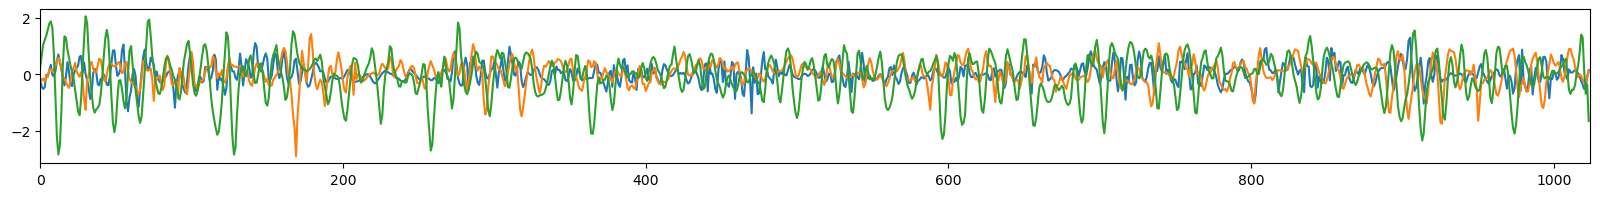

Channel P2


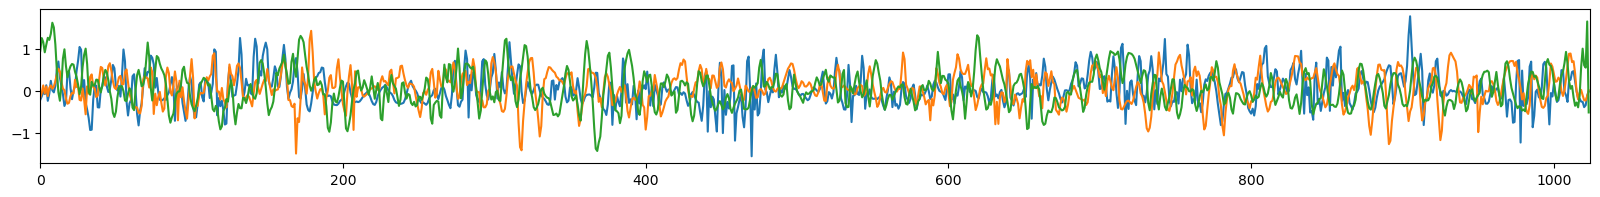

In [9]:
l = 100
x_mean = -4.3159e-06
x_std = 0.4515
x_gen = model.generator((keras.random.normal((l, latent_dim), mean=x_mean, stddev=x_std), sub[:l].to('mps'), pos[:l].to('mps'))).cpu().detach()

for ch in range(8):
    print(f'Channel {channels[ch]}')
    for i in range(10, 3+10, 3):
        plot_overlap(x_gen, n_seg=3, ch=ch, time_dim=1024, start_from=i, show=True)

#### Frequency domain

Effective window size : 4.000 (s)


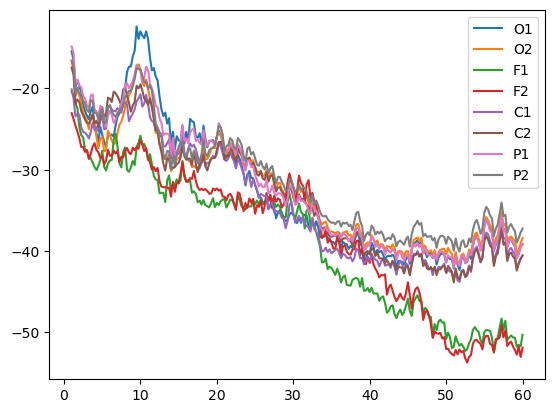

In [10]:
psd, freq = mne.time_frequency.psd_array_welch(x_gen.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=1, fmax=60, n_fft=512)

for i in range(8):
    plt.plot(freq, 10*np.log10(psd[i]), label=channels[i])

plt.legend()
plt.show()

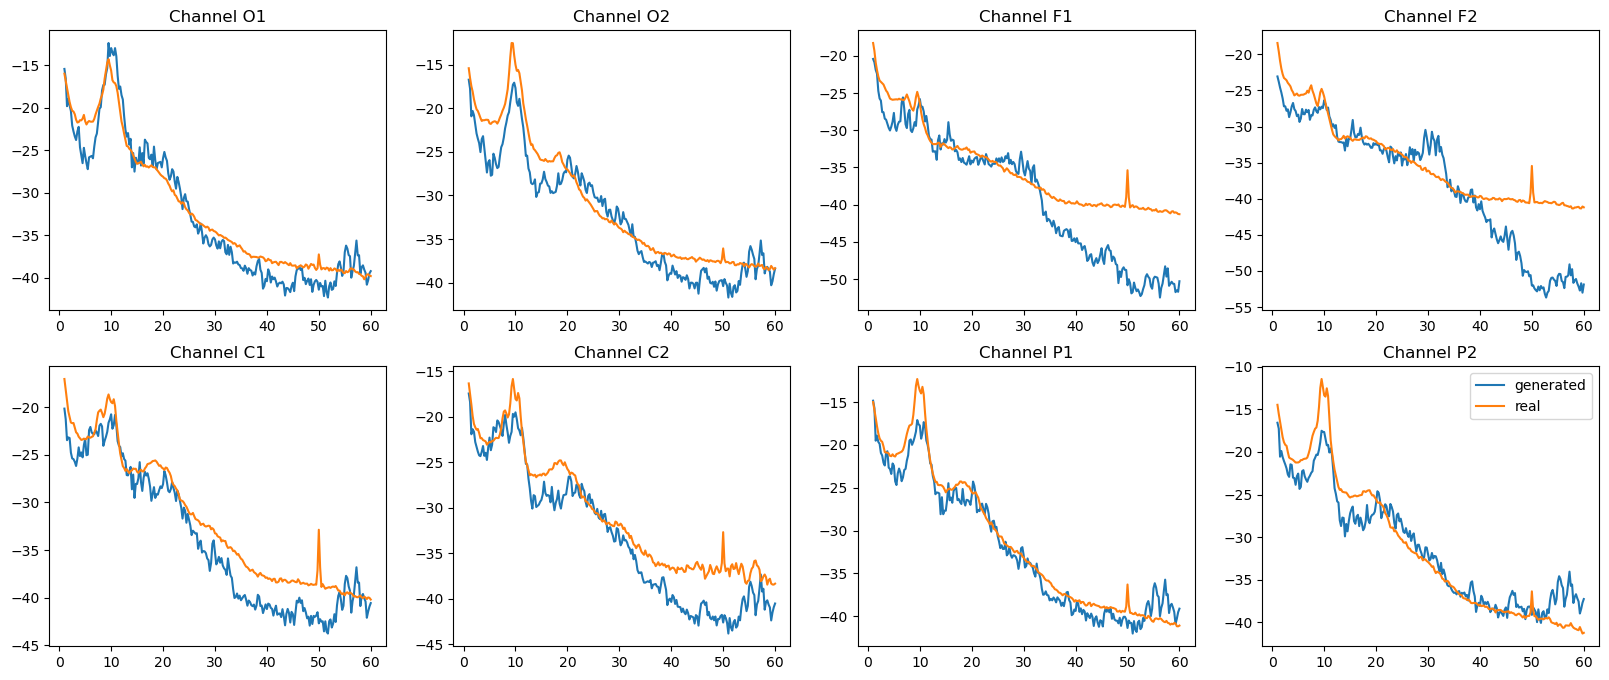

In [13]:
# plot generated data
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(len(channels)):
    plot_psd_multi_channel(x_gen, c=i, label='generated', show=False, db=True, ax=axes[i//4, i%4])
    plot_psd_multi_channel(x[:1024], c=i, label='real', show=False, db=True, ax=axes[i//4, i%4])

plt.legend()
plt.show()

### compared in time domain

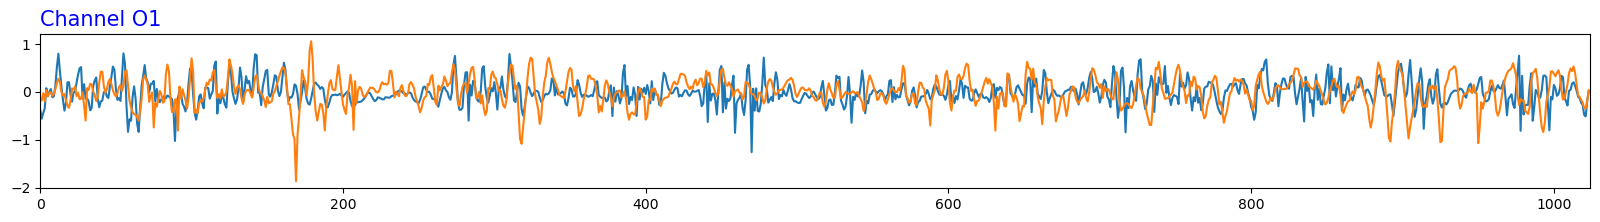

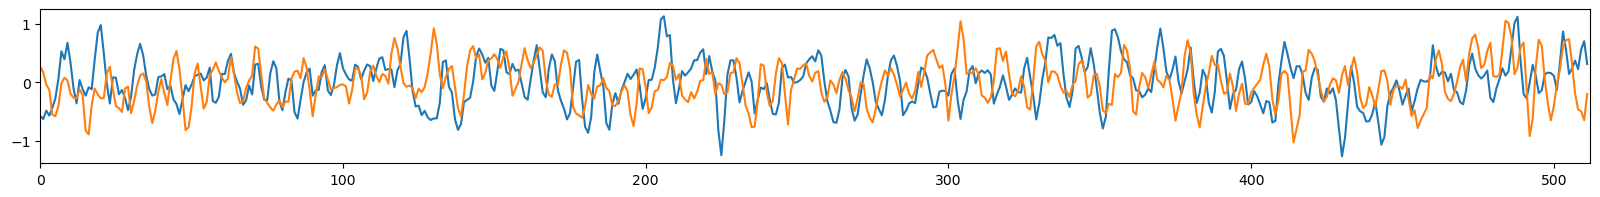

In [16]:
# look at different channels
ch = 0
start_from = 10
n_seg = 2
plot_overlap(x_gen, ch=ch, time_dim=1024, start_from=start_from, n_seg=n_seg, show=False)
plt.title(f'Channel {channels[ch]}', fontsize=15, color='blue', loc='left')

plot_overlap(x, ch=ch, time_dim=512, start_from=start_from, n_seg=n_seg)

In [17]:
x_flat = x.flatten(0, 1)
x_gen_flat = x_gen.flatten(0, 1)

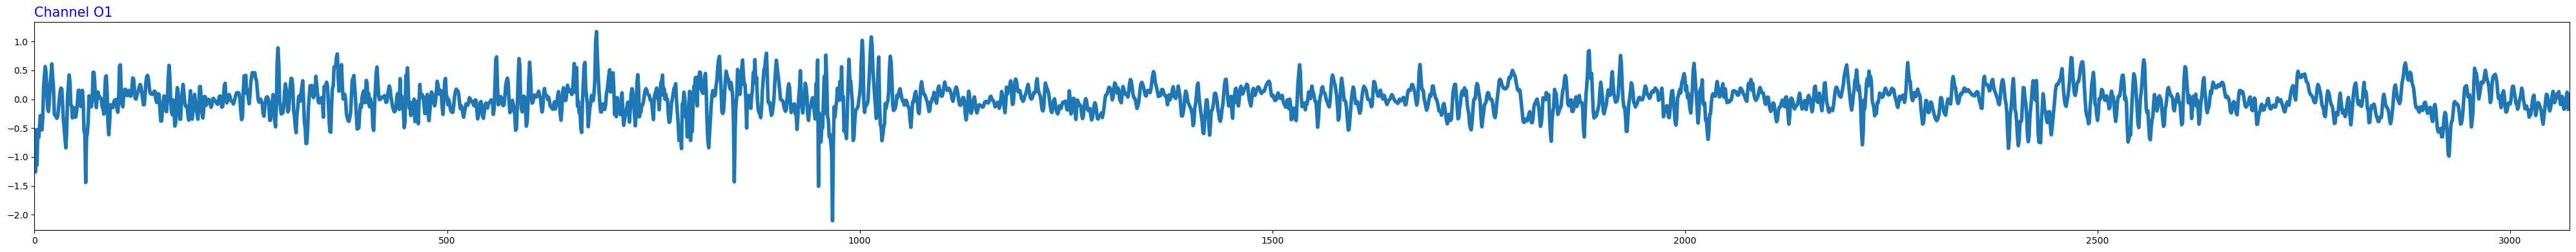

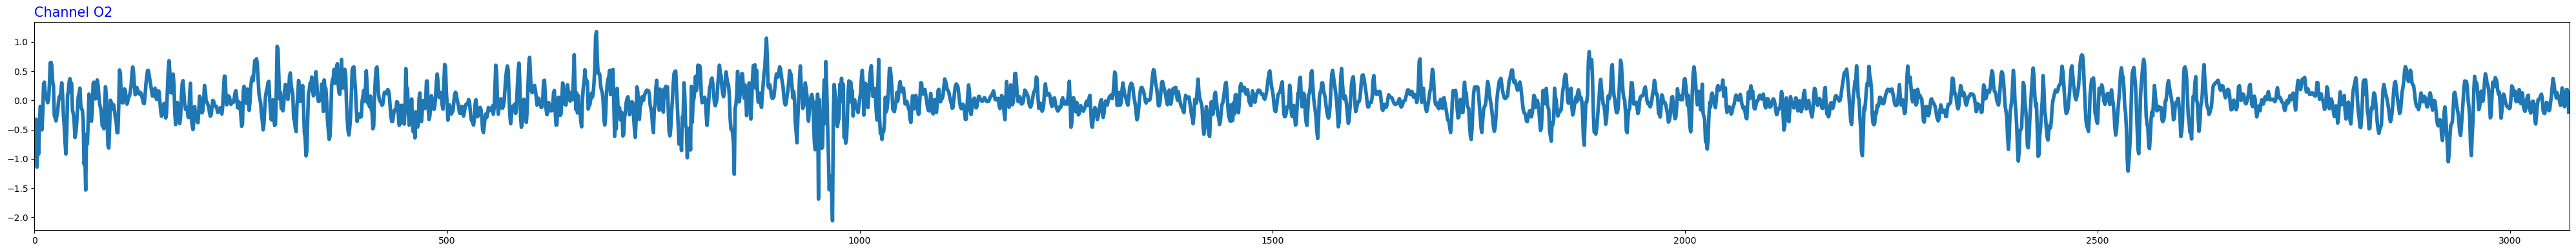

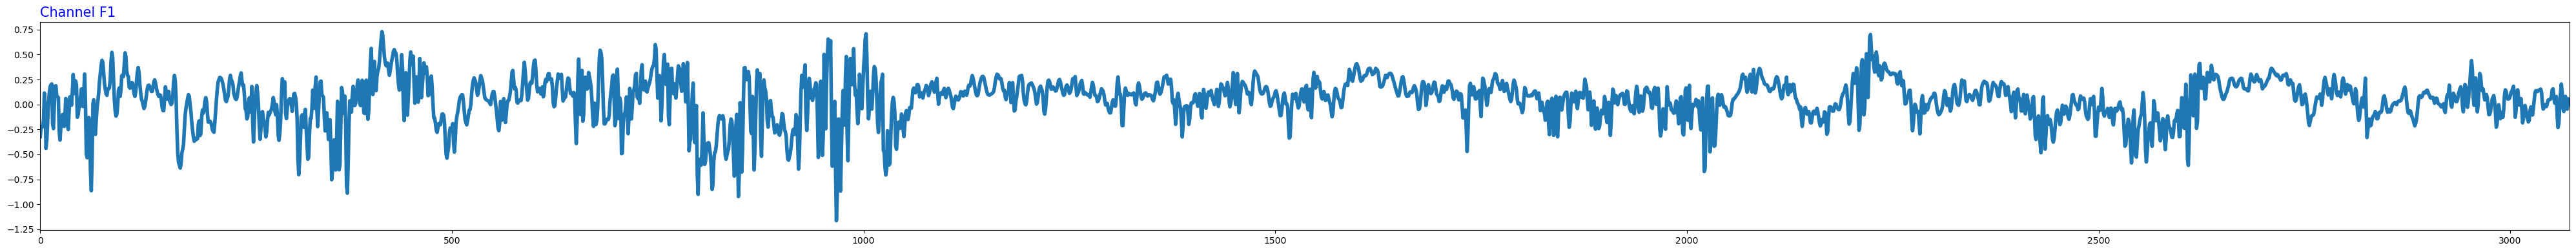

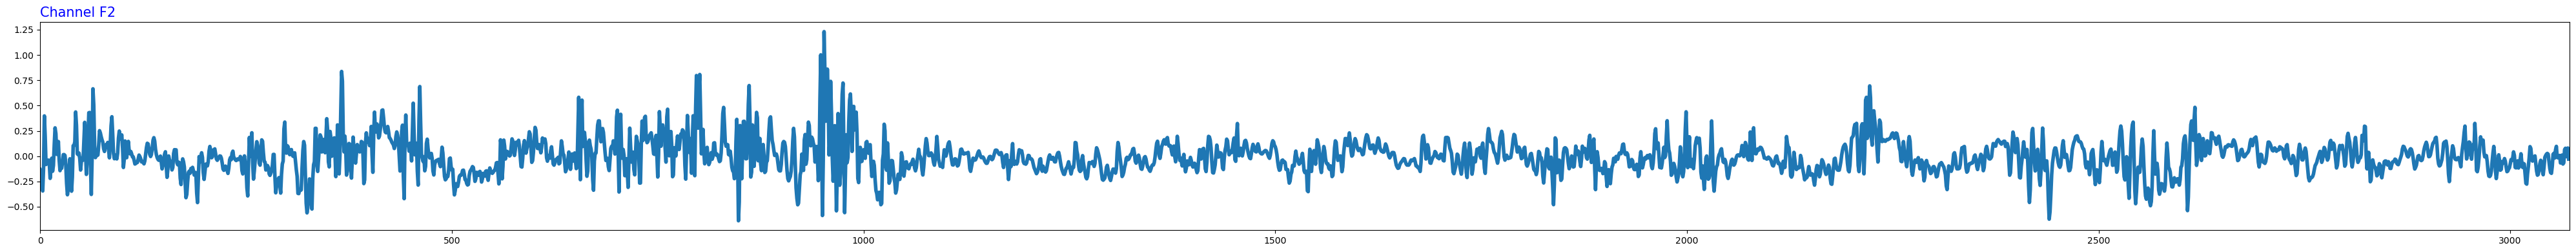

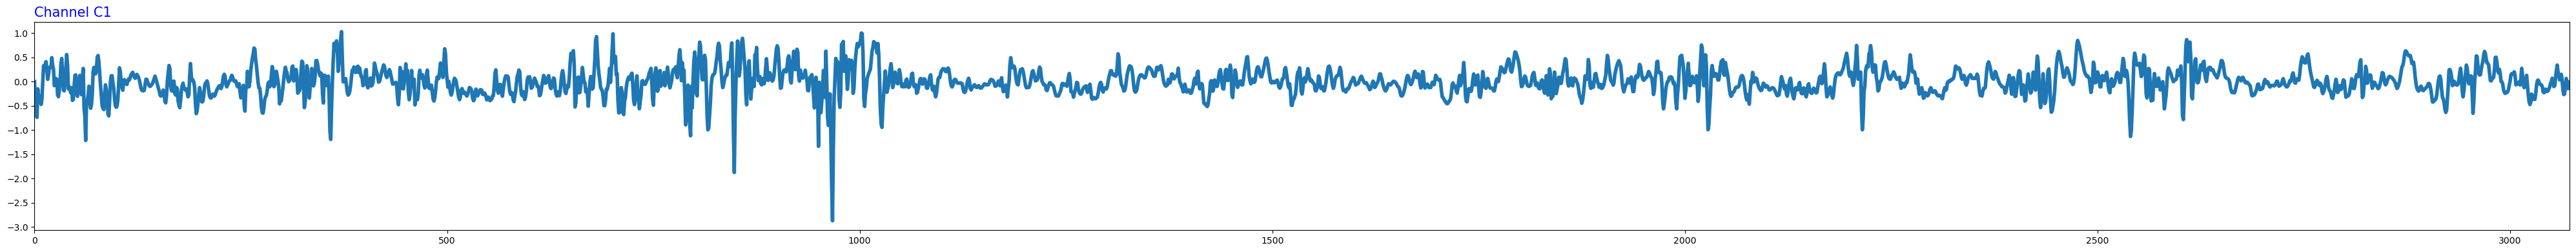

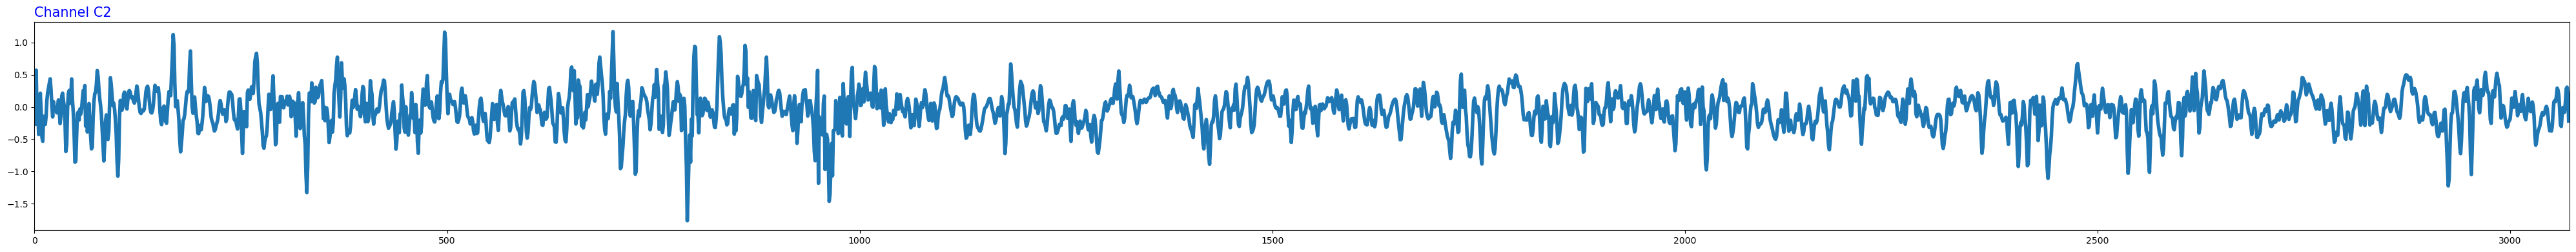

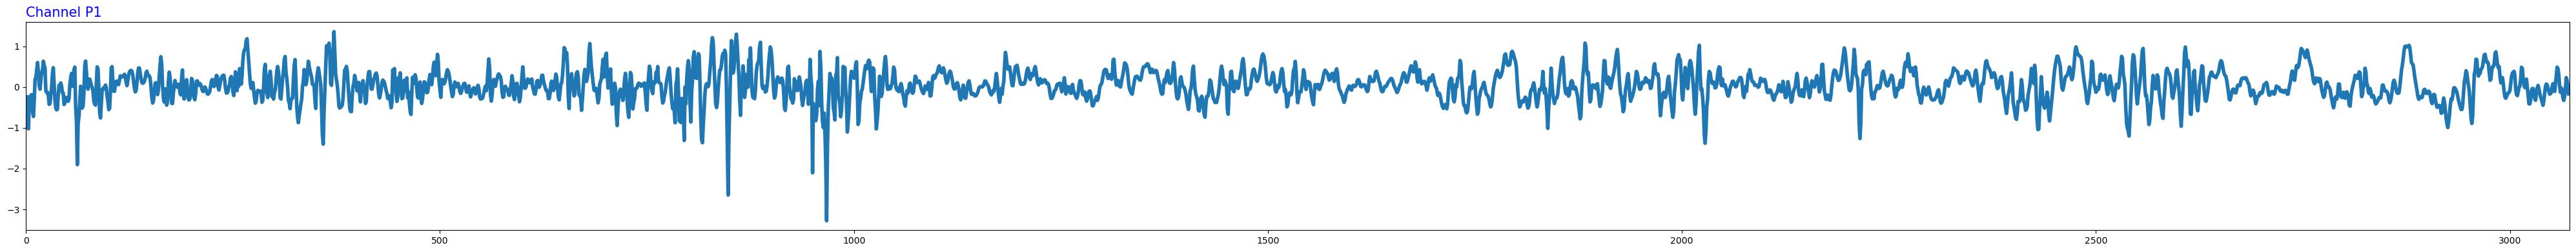

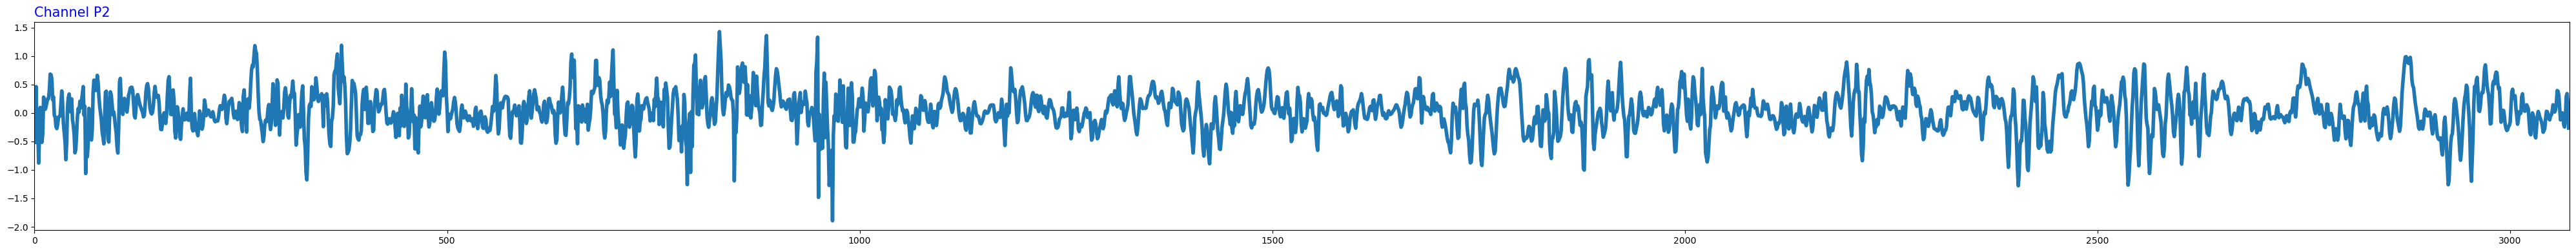

In [18]:
time_lim = 1024 * 3
i = 2

for ch in range(len(channels)):
    plt.figure(figsize=(40, 4))
    plt.plot(x_gen_flat[i*time_lim:(i+1)*time_lim, ch], label=channels[ch], linewidth=4)
    plt.title(f'Channel {channels[ch]}', fontsize=15, color='blue', loc='left')
    plt.xlim(0, time_lim)
    plt.tight_layout()

### features

In [21]:
signal_gen = x_gen.squeeze().numpy()
fids = {}
for j, func in enumerate([hjorth_parameters_multi_channel,
                          spectral_features_multi_channel,
                          time_domain_features_multi_channel]):

    real_f = func(x[:100].permute(0, 2, 1).cpu().detach().numpy())
    real_f = real_f.reshape(100, -1)
    gen_f = func(x_gen.permute(0, 2, 1).cpu().detach().numpy())
    gen_f = gen_f.reshape(100, -1)
    print(f'FID on {func.__name__[:-14]}: {compute_fid(real_f, gen_f)}')  # TODO: consider standardizing the features before computing FID

FID on hjorth_parameters: 1.7521117735328935
FID on spectral_features: 0.912459202444114
FID on time_domain_features: 137.06669790875145


#### critic Performance

In [ ]:
print_act_dist(model, x, sub, pos)

In [20]:
def print_D_performance(x, sub, model, pos):
    return sigmoid(model.critic(x.float().to('mps'), sub.to('mps'), pos.to('mps')).mean().item())

In [23]:
sub_random = torch.randint(0, 202, (1024 ,1))
generated_data = {'x': x_gen, 'sub': sub_random[:1024], 'pos': pos[:1024]}
fake_pred = model.critic(generated_data)

real_data_seg = {'x': x[:100], 'sub': sub[:100], 'pos': pos[:100]}
real_pred = model.critic(real_data_seg)

In [24]:
fake_scores = fake_pred.cpu().detach().numpy().flatten()
real_scores = real_pred.cpu().detach().numpy().flatten()

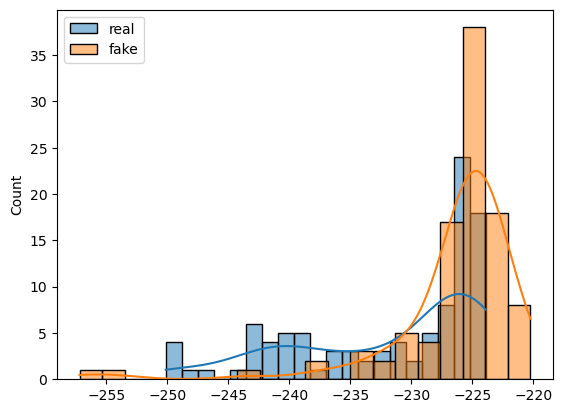

In [25]:
sns.histplot(real_scores, bins=20, alpha=0.5, label='real', kde=True)
sns.histplot(fake_scores, bins=20, alpha=0.5, label='fake', kde=True)
plt.legend()
plt.show()

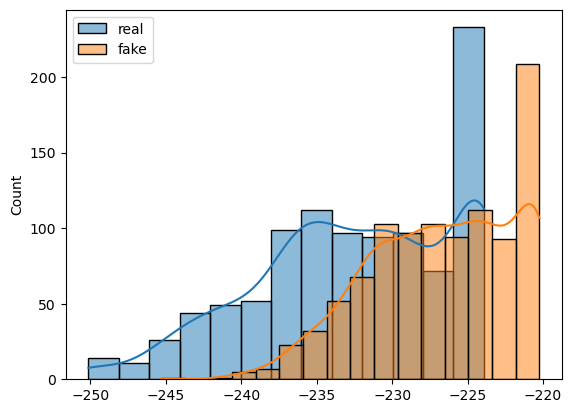

In [26]:
# plot a normal distribution using the mean and std and min and max values of the critic scores
f_scores = np.random.normal(fake_scores.mean(), fake_scores.std(), 1000)
r_scores = np.random.normal(real_scores.mean(), real_scores.std(), 1000)

# Clip the generated scores to the min and max values of the real and fake scores
r_scores = np.clip(r_scores, real_scores.min(), real_scores.max())
f_scores = np.clip(f_scores, fake_scores.min(), fake_scores.max())

sns.histplot(r_scores, label='real', kde=True)
sns.histplot(f_scores, label='fake', kde=True)
plt.legend()

### Downstream task
#### SVM

In [147]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

# import PCA from sklearn
from sklearn.decomposition import PCA

labels = xarray.gender - 1
labels = labels.repeat(x.shape[0]//202)
sub_ids_classifier = sub.squeeze().numpy()

In [ ]:
features = np.zeros((len(sub_ids_classifier), 4096))
critic = model.critic.model

feature_extractor = keras.Model(critic.layers[0].input, critic.layers[-2].output)

subjects = 404
for i in range(x.shape[0]//subjects):
    print(i)
    features[i*subjects:(i+1)*subjects] = feature_extractor(x[i*subjects:(i+1)*subjects].float()).cpu().detach().numpy()

In [154]:
features_decomposed = PCA(n_components=0.95).fit_transform(features)
features_decomposed.shape

(12120, 136)

In [ ]:
cv_g = GroupShuffleSplit(n_splits=5, test_size=0.2)

# add PCA to pipeline
pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('clf', SVC(max_iter=100000, kernel='linear', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features_decomposed, labels, cv=cv_g, groups=sub_ids_classifier, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

In [26]:
cv_s = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_s).mean() * 100:.2f}%', f'±{np.array(scores_s).std() * 100:.2f}%')

Accuracy: 62.03% ±0.87%


#### Freeze the critic and add a new layer

In [4]:
X_input = x
labels = xarray.gender - 1
# y = labels.repeat(x.shape[0]//202)
sub_ids_classifier = sub.squeeze().numpy()

In [259]:
from sklearn.model_selection import StratifiedGroupKFold
# prepare Kfold cross validation
cross_val = False

if cross_val:
    n_splits = 3
    group_kfold = StratifiedGroupKFold(n_splits=n_splits)
    train_val_splits = []
    for train_idx, val_idx in group_kfold.split(x, y, groups=sub_ids_classifier):
        train_val_splits.append((train_idx, val_idx))

    # make sure that the splits are stratified and ther is a balance between the classes
    for train_idx, val_idx in train_val_splits:
        print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

else:
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1)  # random state == 9
    train_idx, val_idx = next(group_shuffle.split(X_input, y, groups=sub_ids_classifier))
    print(np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]), np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

[0.36645963 0.63354037] [0.36585366 0.63414634]


In [ ]:
critic = model.critic.model

# 2. Remove or ignore the last layer (the Dense(1) for the critic’s real/fake task)
#    and connect a new layer of your choice
critic_output = critic.get_layer('dis_flatten').output  # the 4096-dim layer

# 3. Add your new binary classifier
#    e.g., reduce dimension + final sigmoid
x = keras.layers.Dense(256, activation='relu')(critic_output)
x = keras.layers.Dropout(0.3)(x)
new_output = keras.layers.Dense(1, activation='sigmoid')(x)

new_model = keras.Model(inputs=critic.layers[0].input, outputs=new_output)

# 4. Freeze the original layers
for layer in new_model.layers[:-3]:
    layer.trainable = False

# 5. Compile and train
new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


new_model.fit(X_input[train_idx], y[train_idx], 
              epochs=20, 
              batch_size=64,
              validation_data=(X_input[val_idx], y[val_idx]))

## Modify Architecture

Finding out about the architectural limitations...

In [5]:
load_model = False
i = 160
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'

In [ ]:
# 2. MODEL and Plot generated data by the model before training
ld = 64
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=ld, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer=keras.initializers.HeNormal(),
                  interpolation='bilinear')

sub2 = np.arange(0, n_subject).reshape(-1, 1)

x_gen = wgan_gp.generator(keras.random.normal((199, ld), mean=x.mean(), stddev=x.std()), torch.tensor(sub2).to('mps'),
                          pos).cpu().detach()

plot_overlap(x_gen, n_seg=5, ch=0, time_dim=512, start_from=100, show=True)
plot_psd(x_gen, label='generated', show=False, db=True)

In [ ]:
# x_gen = wgan_gp.generator(keras.random.normal((199, ld), mean=x.mean(), stddev=x.std()), torch.tensor(sub2).to('mps'), pos)
# x_gen = x_gen.cpu().detach()
# plot_overlap(x_gen, n_seg=5, ch=0, time_dim=512, start_from=9, show=True)
plot_segment(x_gen, 2, 5, duration=512*8, db=True)
# plot_psd(x_gen, label='generated', show=False, db=True)

In [ ]:
generator = wgan_gp.generator
ly = 18
features = keras.Model(generator.model.layers[0].input, generator.model.layers[ly].output)(keras.random.normal((100, ld), mean=x.mean(), stddev=x.std())).cpu().detach()
print(generator.model.layers[ly].name)

In [68]:
def plot_psd(x, ch=[0], fmin=1, fmax=60, n_fft=512, db=True, ax=None):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, :, ch].flatten().numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd)
        # ax.set_xlabel('Frequency (Hz)')
        # ax.set_ylabel('Power Spectral Density (dB/Hz)')
    else:
        plt.plot(freq, psd,)
        plt.xlabel('Frequency (Hz)')

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)
ch = [0]
for i in range(8):
    if i != 0:
        ch = ch + [i]
    plot_psd(features, ch=ch, n_fft=512, db=True, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Neuron {i+1}')

fig.tight_layout()
fig.title('Power Spectral Density (dB/Hz) of the Neurons')
    # axes[0].set_ylabel('Power Spectral Density (dB/Hz)')

## Improve efficiency of the training

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# data = {'x': x, 'sub': sub, 'pos': pos}
# data = TensorDataset(data['x'], data['sub'], data['pos'])
# data = DataLoader(data, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

# Custom collate_fn to transfer tensors to the GPU
def collate_fn(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(batch[10][2])
    x, sub, pos = batch
    return x.to(device), sub.to(device), pos.to(device)

data = TensorDataset(x, sub, pos)
data = DataLoader(data, batch_size=64, shuffle=True, num_workers=0, pin_memory=True,
                #   collate_fn=collate_fn
                  )

In [28]:
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.0005, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=5.0)

In [ ]:
for batch in data:
    x, sub, pos = batch
    print(x.device, sub.device, pos.device)
    break

In [ ]:
wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)

In [ ]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats(10)  # Print top 10 functions by cumulative time


In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU],
             schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
             on_trace_ready=None,
            #  record_shapes=True
             ) as prof:
    wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)
    print('Model training finished')
print(prof.key_averages().table(sort_by='cpu_time_total', row_limit=10))


In [ ]:
print(prof.key_averages().table(sort_by='cpu_time_total', row_limit=20))

In [58]:
positions = torch.randint(0, 20, (20, 2))


In [59]:
import torch
import math
dimension = 256
margin = 0.2
*O, D = positions.shape
n_freqs = (dimension // 2)**0.5
freqs_y = torch.arange(n_freqs, device=positions.device)
freqs_x = freqs_y[:, None]
width = 1 + 2 * margin
positions = positions + margin
p_x = 2 * math.pi * freqs_x / width
p_y = 2 * math.pi * freqs_y / width
positions = positions[..., None, None, :]
loc = (positions[..., 0] * p_x + positions[..., 1] * p_y).view(*O, -1)
emb = torch.cat([
    torch.cos(loc),
    torch.sin(loc),
], dim=-1)

In [ ]:
import torch
a = torch.randn(1, 512, 1).half()
b = torch.randn(1, 512, 6).half()
torch.einsum('btd,bto->bod', b, a)

In [ ]:
eeg = torch.randn(2, 512, 6)
weights = torch.randn(2, 512, 2)
out = torch.einsum("bct,boc->bot", eeg, weights)

In [ ]:
from src.EEGModalNet.models.common import ChannelMerger

cm = ChannelMerger(6, 288)

x_ = x.half()
cm(x_.half(), pos.half()).shape

## Scheduled Learning Rate

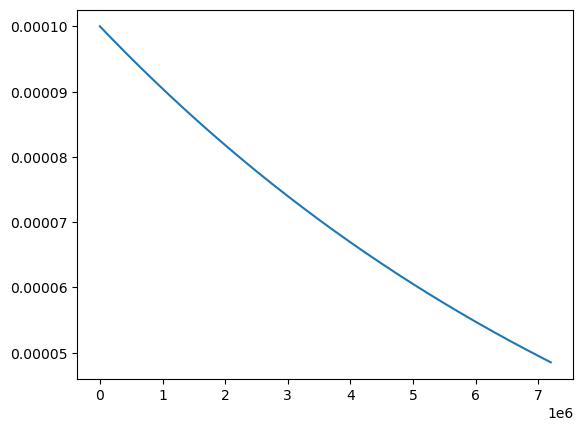

In [98]:
def decayed_learning_rate(steps, initial_learning_rate, decay_steps, decay_rate):
    lr = [initial_learning_rate * decay_rate ** (step / decay_steps) for step in range(steps)]
    plt.plot(np.arange(steps), lr)

decayed_learning_rate(90*80000, 0.0001, 100000, 0.99)